## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

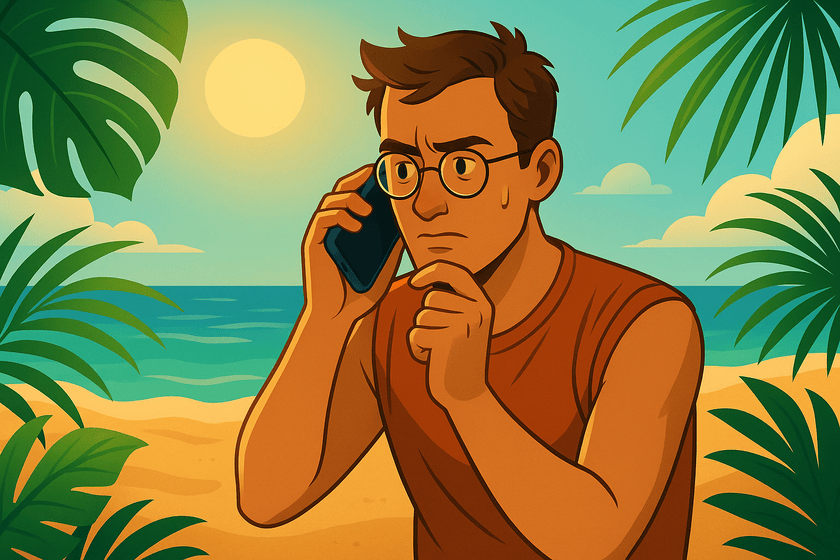

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

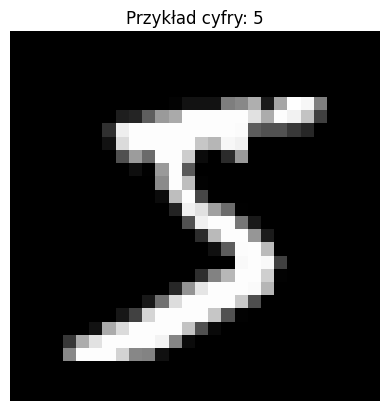

In [ ]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim import Adam
import time
import numpy as np
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Najpierw przygotuje dane.

In [ ]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
        253, 253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253, 253,
        253, 253, 253, 253, 251,  93,  82,  82,  56,  39,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253, 253, 253, 253,
        253, 198, 182, 247, 241,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156, 107, 253, 253,
        205,  11,   0,  43, 154,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253,
         90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 139, 253,
        190,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 190,
        253,  70,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35,
        241, 225, 160, 108,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         81, 240, 253, 253, 119,  25,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  45, 186, 253, 253, 150,  27,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  16,  93, 252, 253, 187,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 249, 253, 249,  64,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  46, 130, 183, 253, 253, 207,   2,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  39,
        148, 229, 253, 253, 253, 250, 182,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  24, 114, 221,
        253, 253, 253, 253, 201,  78,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  23,  66, 213, 253, 253,
        253, 253, 198,  81,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  18, 171, 219, 253, 253, 253, 253,
        195,  80,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  55, 172, 226, 253, 253, 253, 253, 244, 133,
         11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 136, 253, 25

In [ ]:
y_train[0]

np.uint8(5)

In [ ]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

Dane x_train i x_test są w formacie (N, H, W), aby były zgodne z pytorch musze je przerobić na (N, C, H, W), gdzie C to wymiar kanałów. Dodatkowo warto znormalizować dane. Na koniec należy przekonwertować je z numpy.ndarray na Tensory.

In [ ]:
# normalizacja
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
# konwersja na tensor
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)

In [ ]:
# dodanie wymiaru kanałów
x_train = x_train.unsqueeze(1)
x_test = x_test.unsqueeze(1)

In [ ]:
x_train.shape

torch.Size([60000, 1, 28, 28])

In [ ]:
x_train[0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

Dane są już w odpowiednim formacie (N, C, H, W) jako float32, znormalizowane, jako tensory pytorch.

Teraz wypada wydzielić zbiór walidacyjny i stworzyc loadery. Zbiór walidacyjny wydziele ze zbioru treningowego.

In [ ]:
val_size = 5000 # 5k z 60k -> 8.3% zbioru treningowego
train_size = len(x_train) - val_size

# przekształcenie na datasety
train_full = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

In [ ]:
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Funckje pomocnicze

In [ ]:
def run_epoch(model, loader, train: bool, optimizer, criterion):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

def train(model, train_loader, val_loader, epochs, optimizer, criterion):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    start = time.time()
    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, True, optimizer, criterion)
        val_loss, val_acc = run_epoch(model, val_loader, False, optimizer, criterion)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    print(f'Training time: {time.time() - start:.1f}s')
    return history

def test(model, test_loader, criterion):
    test_loss, test_acc = run_epoch(model, test_loader, False, None, criterion)
    return test_loss, test_acc


# Sieć MLP

In [ ]:
class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, *args, **kwargs):
        super(MyMLP, self).__init__(*args, **kwargs)
        self.flatten = nn.Flatten() # splaszczenie obrazu do jednego wymiaru
        self.fc1 = nn.Linear(input_size, hidden_size) # pierwsza warstwa liniowa
        self.relu = nn.ReLU() # funkcja aktywacji ReLU
        self.fc2 = nn.Linear(hidden_size, output_size) # druga warstwa liniowa

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Dane mają format 28x28, zatem neuronów wejściowych będzie 784. Wyjściowych będzie tyle ile jest klas - 10. Z warstwą ukrytą można poeksperymentować.

In [ ]:
input_dim = x_train.shape[2] * x_train.shape[3]
hidden_dim = 128
output_dim = 10
input_dim

784

Trening

In [ ]:
model = MyMLP(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001) # Ale kim jest ten Adam???
epochs = 15
history = train(model, train_loader, val_loader, epochs, optimizer, criterion)

Epoch 1/15 | Train Loss: 0.3028 | Train Acc: 0.9157 | Val Loss: 0.1832 | Val Acc: 0.9456
Epoch 2/15 | Train Loss: 0.1320 | Train Acc: 0.9612 | Val Loss: 0.1233 | Val Acc: 0.9640
Epoch 3/15 | Train Loss: 0.0889 | Train Acc: 0.9733 | Val Loss: 0.1086 | Val Acc: 0.9672
Epoch 4/15 | Train Loss: 0.0663 | Train Acc: 0.9795 | Val Loss: 0.0918 | Val Acc: 0.9732
Epoch 5/15 | Train Loss: 0.0519 | Train Acc: 0.9841 | Val Loss: 0.0886 | Val Acc: 0.9740
Epoch 6/15 | Train Loss: 0.0419 | Train Acc: 0.9872 | Val Loss: 0.0799 | Val Acc: 0.9758
Epoch 7/15 | Train Loss: 0.0329 | Train Acc: 0.9897 | Val Loss: 0.0910 | Val Acc: 0.9726
Epoch 8/15 | Train Loss: 0.0254 | Train Acc: 0.9923 | Val Loss: 0.0996 | Val Acc: 0.9714
Epoch 9/15 | Train Loss: 0.0204 | Train Acc: 0.9938 | Val Loss: 0.0856 | Val Acc: 0.9752
Epoch 10/15 | Train Loss: 0.0170 | Train Acc: 0.9946 | Val Loss: 0.0878 | Val Acc: 0.9748
Epoch 11/15 | Train Loss: 0.0140 | Train Acc: 0.9957 | Val Loss: 0.0912 | Val Acc: 0.9746
Epoch 12/15 | Train

Jeszcze sobie zobrazuje jak szło trenowanie względem zbioru walidacyjnego.

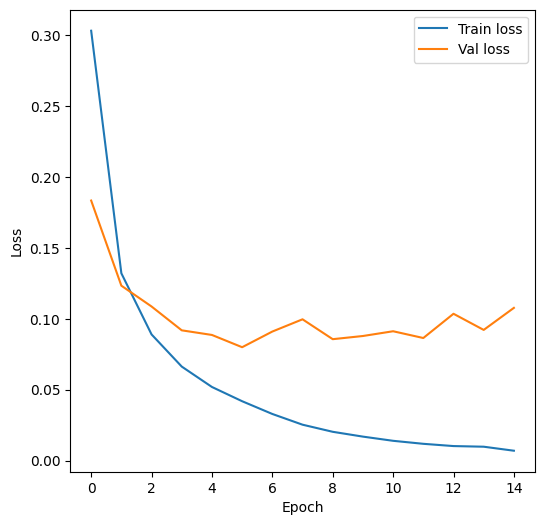

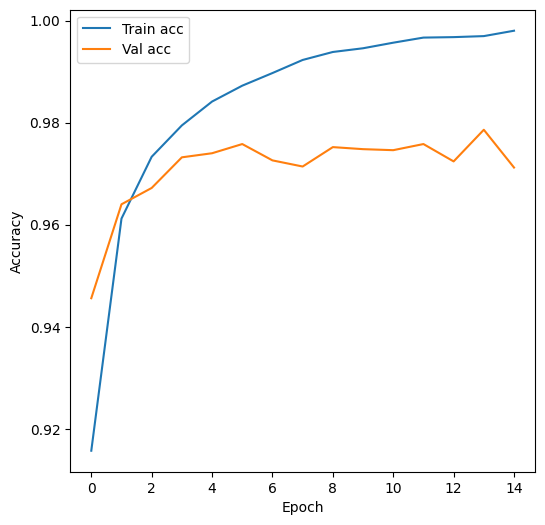

In [ ]:
# Loss
plt.figure(figsize=(6,6))
plt.plot(history['train_loss'], label='Train loss')
plt.plot(history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(6,6))
plt.plot(history['train_acc'], label='Train acc')
plt.plot(history['val_acc'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Widać, że najlepiej jest trenować model na 5-6 epokach dla jak najlepszego accuracy zbioru walidacyjnego. Dalej nastepuje overfitting i zbyt małe różnice w accuracy, żeby tracić na to zasoby.

In [ ]:
test_loss, test_acc = test(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.0997 | Test Acc: 0.9770


Mój baseline to accuracy na poziomie 97,7% na zwykłej sieci MLP z jedną wartswą ukrytą z 128 neuronami.

# CNN

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MyCNN, self).__init__(*args, **kwargs)

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

Trening

In [ ]:
model_cnn = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_cnn.parameters(), lr=0.001)
epochs = 15
history = train(model_cnn, train_loader, val_loader, epochs, optimizer, criterion)
test_loss, test_acc = test(model_cnn, test_loader, criterion)

Epoch 1/15 | Train Loss: 0.1788 | Train Acc: 0.9452 | Val Loss: 0.0727 | Val Acc: 0.9778
Epoch 2/15 | Train Loss: 0.0548 | Train Acc: 0.9827 | Val Loss: 0.0552 | Val Acc: 0.9820
Epoch 3/15 | Train Loss: 0.0377 | Train Acc: 0.9882 | Val Loss: 0.0668 | Val Acc: 0.9776
Epoch 4/15 | Train Loss: 0.0291 | Train Acc: 0.9906 | Val Loss: 0.0432 | Val Acc: 0.9862
Epoch 5/15 | Train Loss: 0.0219 | Train Acc: 0.9931 | Val Loss: 0.0463 | Val Acc: 0.9862
Epoch 6/15 | Train Loss: 0.0183 | Train Acc: 0.9941 | Val Loss: 0.0701 | Val Acc: 0.9832
Epoch 7/15 | Train Loss: 0.0132 | Train Acc: 0.9957 | Val Loss: 0.0460 | Val Acc: 0.9866
Epoch 8/15 | Train Loss: 0.0109 | Train Acc: 0.9963 | Val Loss: 0.0391 | Val Acc: 0.9894
Epoch 9/15 | Train Loss: 0.0107 | Train Acc: 0.9965 | Val Loss: 0.0462 | Val Acc: 0.9894
Epoch 10/15 | Train Loss: 0.0071 | Train Acc: 0.9977 | Val Loss: 0.0527 | Val Acc: 0.9864
Epoch 11/15 | Train Loss: 0.0087 | Train Acc: 0.9969 | Val Loss: 0.0385 | Val Acc: 0.9888
Epoch 12/15 | Train

Wyniki

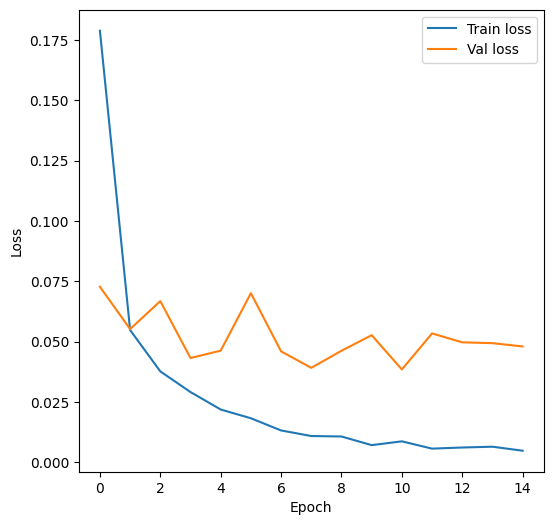

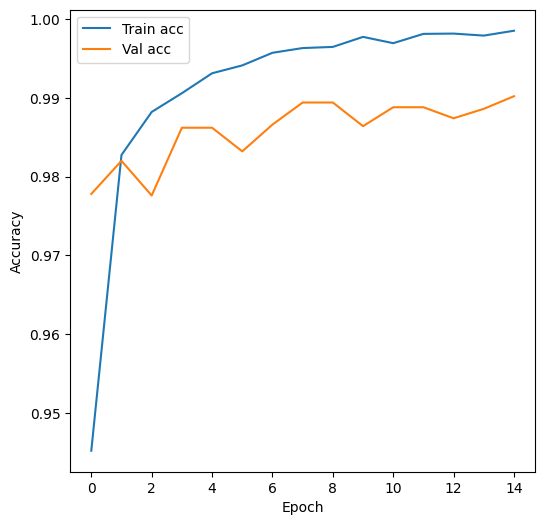

In [ ]:
# Loss
plt.figure(figsize=(6,6))
plt.plot(history['train_loss'], label='Train loss')
plt.plot(history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(6,6))
plt.plot(history['train_acc'], label='Train acc')
plt.plot(history['val_acc'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.0348 | Test Acc: 0.9908


Efektywnosc konwolucyjnej sieci jest lepsza niż zwykłej, wymaga też mniej epok, ale w moim przypadku się dłużej trenuje. (Pewnie dlatego, że coś źle zrobiłem)